<a id="content"></a>
## Notebook content

This notebook contains steps and code to demonstrate AutoAI pipeline. This notebook introduces commands for getting data,  
pipeline model, model inspection and testing.

Some familiarity with Python is helpful. This notebook uses Python 3.

## Notebook goals

-  inspection of trained pipeline via graphical vizualization and source code preview
-  pipeline evaluation
-  pipeline deployment and webservice scoring.

## Contents

This notebook contains the following parts:

1.	[Setup](#setup)         
    a.  [AutoAI experiment metadata](#variables_definition)      
2.	[Pipeline inspection](#inspection)      
    a.  [Get historical optimizer instance](#get_hist_and_train)      
    b.  [Get pipeline model](#get_pipeline)      
    c.  [Preview pipeline model as python code](#preview_model_to_python_code)      
    d.  [Visualize pipeline model](#visualize_pipeline)      
    e.  [Read training and holdout data](#train_holdout_read)        
    f.  [Test pipeline model locally](#test_model)       
3.	[Pipeline refinery and testing (optional)](#refinery)
    a.  [Pipeline definition source code](#pipeline_definition)      
    b.  [Lale library](#lale_library)      
4.	[Deploy and score](#scoring)       
    a.  [Insert WML credentials](#wml_credentials)   
    b.  [Create deployment](#deployment)      
    c.  [Score webservice](#online_scoring)        
    d.  [Delete deployment](#delete_deployment)       
5.  [Authors](#authors)      

<a id="setup"></a>
# Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:
 - `watson-machine-learning-client` uninstallation of the old client
 - `watson-machine-learning-client-V4` installation
 - `autoai-libs` installation/upgrade
 - `lightgbm` or `xgboost` installation/downgrade if they are needed

In [1]:
!pip uninstall watson-machine-learning-client -y

Uninstalling watson-machine-learning-client-1.0.376:
  Successfully uninstalled watson-machine-learning-client-1.0.376


In [2]:
!pip install -U watson-machine-learning-client-V4

     |████████████████████████████████| 1.2MB 7.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 26.9MB/s eta 0:00:01
     |████████████████████████████████| 768kB 41.2MB/s eta 0:00:01
     |████████████████████████████████| 225kB 41.8MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/37/9c/c4/a2c610ccb877d37c2cb87a5bfe55845fecffd6bb01bcd5e9d5
  Stored in directory: /home/dsxuser/.cache/pip/wheels/75/93/e6/23071b2c037147a0993d34b64a03e51abca84435fc9cd6a278
  Stored in directory: /home/dsxuser/.cache/pip/wheels/23/d9/d7/43fd95b014eed89466154d8373bf4cffbb3d972de7841e213c
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3transfer
  Found existing installation: ibm-cos-sdk-core 2.4.3
    Uninstalling ibm-cos-sdk-core-2.4.3:
      Successfully uninstalled ibm-cos-sdk-core-2.4.3
  Found existing installation: ibm-cos-sdk-s3transfer 2.4.3
    Uninstalling ibm-cos-sdk-s3transfer-2.4.3:
      Successfully uninstalled ibm-cos-sdk-s3transfer-2.4.3
  

In [3]:
!pip install -U autoai-libs
!pip install -U xgboost==0.90

     |████████████████████████████████| 4.3MB 7.7MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 43.7MB/s eta 0:00:01█████████▌   | 9.3MB 43.7MB/s eta 0:00:01
     |████████████████████████████████| 14.6MB 41.7MB/s eta 0:00:01
     |████████████████████████████████| 102kB 32.0MB/s ta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
  Found existing installation: category-encoders 2.0.0
    Uninstalling category-encoders-2.0.0:
      Successfully uninstalled category-encoders-2.0.0
  Found existing installation: autoai-libs 1.10.5
    Uninstalling autoai-libs-1.10.5:
      Successfully uninstalled autoai-libs-1.10.5
     |████████████████████████████████| 142.8MB 284kB/s  eta 0:00:01     |

<a id="variables_definition"></a>
### AutoAI experiment metadata

This cell defines COS credentials required to retrieve AutoAI pipeline.

In [4]:
# The code was removed by Watson Studio for sharing.

Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio

In [5]:
experiment_metadata = dict(
   prediction_type='regression',
   prediction_column='LV ActivePower (kW)',
   test_size=0.1,
   scoring='neg_root_mean_squared_error',
   csv_separator=',',
   excel_sheet=0,
   max_number_of_estimators=2,
   training_data_reference = training_data_reference,
   training_result_reference = training_result_reference)

pipeline_name='Pipeline_4'

<a id="inspection"></a>
## Pipeline inspection
In this section you will get the trained pipeline model from the AutoAI experiment and inspect it.  
You will see pipeline as a pythone code, graphically visualized and at the end, you will perform a local test.


<a id="get_hist_and_train"></a>
### Get historical optimizer instance

The next cell contains code for retrieving fitted optimizer.

In [6]:
from watson_machine_learning_client.experiment import AutoAI

optimizer = AutoAI().runs.get_optimizer(metadata=experiment_metadata)

<a id="get_pipeline"></a>
### Get pipeline model

The following cell loads selected AutoAI pipeline model. If you want to get pure scikit-learn pipeline specify `as_type='sklearn'` parameter. By default enriched scikit-learn pipeline is returned `as_type='lale'`.

In [7]:
pipeline_model = optimizer.get_pipeline(pipeline_name=pipeline_name)

[04:12:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<a id="preview_model_to_python_code"></a>
### Preview pipeline model as python code
In the next cell, downloaded pipeline model could be previewed as a python code.  
You will be able to see what exact steps are involved in model creation.

In [8]:
pipeline_model.pretty_print(combinators=False, ipython_display=True)

```python
from autoai_libs.transformers.exportable import ColumnSelector
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.lib.autoai_libs import float32_transform
from lale.lib.autoai_libs import TNoOp
from xgboost import XGBRegressor
from lale.operators import make_pipeline

column_selector = ColumnSelector(columns_indices_list=[1, 2, 3])
numpy_column_selector = NumpyColumnSelector(columns=[0, 1, 2])
float_str2_float = FloatStr2Float(dtypes_list=['float_num', 'float_num', 'float_num'], missing_values_reference_list=[])
numpy_replace_missing_values = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
t_no_op = TNoOp(name='no_action', datatypes='x', feat_constraints=[])
xgb_regressor = XGBRegressor(gamma=0.005463972762012136, learning_rate=0.020646653697296034, min_child_weight=4, missing=float('nan'), n_estimators=1374, n_jobs=2, random_state=33, reg_alpha=0.15726291585838856, reg_lambda=0.1, silent=True, subsample=0.9760130894800576, verbosity=0)
pipeline = make_pipeline(column_selector, numpy_column_selector, float_str2_float, numpy_replace_missing_values, num_imputer, opt_standard_scaler, float32_transform(), t_no_op, xgb_regressor)
```

<a id="visualize_pipeline"></a>
### Visualize pipeline model

Preview pipeline model stages as graph. Each node's name links to detailed description of the stage.


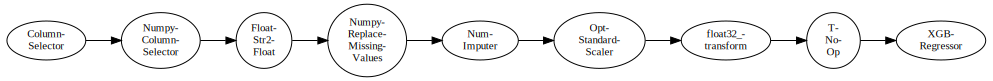

In [9]:
pipeline_model.visualize()

<a id="train_holdout_read"></a>
### Read training and holdout data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

In [10]:
training_df, holdout_df = optimizer.get_data_connections()[0].read(with_holdout_split=True)

train_X = training_df.drop([experiment_metadata['prediction_column']], axis=1).values
train_y = training_df[experiment_metadata['prediction_column']].values

test_X = holdout_df.drop([experiment_metadata['prediction_column']], axis=1).values
y_true = holdout_df[experiment_metadata['prediction_column']].values

<a id="test_model"></a>
### Test pipeline model locally
**Note**: you can chose the metric to evaluate the model by your own, this example contains only a basic scenario.

In [11]:
from sklearn.metrics import r2_score

predictions = pipeline_model.predict(test_X)
score = r2_score(y_true=y_true, y_pred=predictions)
print('r2_score: ', score)

r2_score:  0.9275604148044272


<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

<a id="wml_credentials"></a>
### Connect to WML client in order to create deployment
**Action:** Next you will need credentials for Watson Machine Learning and training run_id:
 - go to [Cloud catalog resources list](https://cloud.ibm.com/resources)
 - click on Services and chose Machine Learning service. Once you are there
 - click the **Service Credentials** link on the left side of the screen
 - click to expand specific credentials name.
 - copy and paste your WML credentials into the cell below

*Take in mind that WML Service instance should be the same as used to generate this notebook.*

In [12]:
wml_credentials = {
  "apikey": "7wQ88zDvFNwL0LqNVd0pSYhxZAEbnYbt-RsKJpXFE64h",
  "iam_apikey_description": "Auto-generated for key 8fd42b26-16cc-46a7-a758-2fd0b3e8ddf5",
  "iam_apikey_name": "Service credentials-2",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/c66c20bcff91488bbd4a6d17ecdb501e::serviceid:ServiceId-7bf3d94a-7219-4bed-b1c9-19a59d84a258",
  "instance_id": "961035e2-1351-4c15-a06c-fb277abdd7f0",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

<a id="deployment"></a>
### Create deployment

**Action**: If you want to deploy refined pipeline please change the `pipeline_model` to `new_pipeline`.
 
If you prefer you can also change the `deployment_name`.

In [13]:
from watson_machine_learning_client.deployment import WebService

service = WebService(wml_credentials)

service.create(
    model=pipeline_model,
    metadata=experiment_metadata,
    deployment_name=f'{pipeline_name}_webservice'
)

Preparing an AutoAI Deployment...
[04:17:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Published model uid: 4c44764d-2595-4fb3-978e-c1681e7c080d
Deploying model 4c44764d-2595-4fb3-978e-c1681e7c080d using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '4c44764d-2595-4fb3-978e-c1681e7c080d' started

#######################################################################################


initializing.......
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f58d24d5-30be-4aed-8eab-a3cc6bc5d354'
------------------------------------------------------------------------------------------------




Deployment object could be printed to show basic information:

In [14]:
print(service)

name: Pipeline_4_webservice, id: f58d24d5-30be-4aed-8eab-a3cc6bc5d354, scoring_url: https://eu-gb.ml.cloud.ibm.com/v4/deployments/f58d24d5-30be-4aed-8eab-a3cc6bc5d354/predictions, asset_id: 4c44764d-2595-4fb3-978e-c1681e7c080d


To be able to show all available information about deployment use `.get_params()` method:

In [15]:
service.get_params()

{'entity': {'asset': {'href': '/v4/models/4c44764d-2595-4fb3-978e-c1681e7c080d?rev=8cb0b6ba-dfdf-461c-b5fb-a7c56e4a57ea',
   'id': '4c44764d-2595-4fb3-978e-c1681e7c080d',
   'rev': '8cb0b6ba-dfdf-461c-b5fb-a7c56e4a57ea'},
  'custom': {},
  'description': '',
  'name': 'Pipeline_4_webservice',
  'online': {},
  'status': {'online_url': {'url': 'https://eu-gb.ml.cloud.ibm.com/v4/deployments/f58d24d5-30be-4aed-8eab-a3cc6bc5d354/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2020-06-24T04:18:01.472Z',
  'description': '',
  'guid': 'f58d24d5-30be-4aed-8eab-a3cc6bc5d354',
  'href': '/v4/deployments/f58d24d5-30be-4aed-8eab-a3cc6bc5d354',
  'id': 'f58d24d5-30be-4aed-8eab-a3cc6bc5d354',
  'modified_at': '2020-06-24T04:18:01.472Z',
  'name': 'Pipeline_4_webservice',
  'parent': {'href': ''}}}

<a id="online_scoring"></a>
### Score webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [16]:
predictions = service.score(payload=holdout_df.drop([experiment_metadata['prediction_column']], axis=1).iloc[:10])
predictions

{'predictions': [{'fields': ['prediction'],
   'values': [[3314.6689453125],
    [9.199421882629395],
    [3449.915771484375],
    [2197.9228515625],
    [2619.97509765625],
    [1340.8221435546875],
    [2882.51123046875],
    [92.50337982177734],
    [624.8418579101562],
    [9.199421882629395]]}]}